# LIMPIEZA DEL DATAFRAME DE VUELOS

## En este Notebook se va a realizar la limpieza de los registros de vuelos obtenidos anteriormente para el scrappeo de los años 2017, 2018 y 2019. El resultado final de la limpieza es un DataFrame con las siguientes columnas:

- **flight_id**: Columna con un id único para cada vuelo, para poder relacionarlo posteriormente con el resto de datos.
- **Departure_date_time**: Columna en formato *Datetime* con la fecha y la hora prevista para la salida del vuelo.
- **cod_flight_IATA**: Código IATA del vuelo.
- **cod_flight_ICAO**: Código ICAO del vuelo.
- **day**: Columna en formato *Datetime* con el día del vuelo.
- **week_day**: Columna con el día de la semana.
- **status**: Columna con el estado del vuelo(Landed, Cancelled, Derived..).
- **airliner**: Nombre del operador del vuelo.
- **cod_airliner_IATA**: Código IATA de la compañia.
- **cod_airliner_ICAO**: Código ICAO de la compañia.
- **Scheduled_dep**: Horario programado para la salida del vuelo.
- **depart_time**: Hora real de la salida del vuelo.
- **dep_situation**: Estado de la salida del vuelo(late, early, on time..).
- **dep_mins_of_delay**: Minutos de retraso o de adelanto en la salida del vuelo.
- **city**: Ciudad del aeropuerto de destino.
- **cod_airport_IATA**: Código IATA del aeropuerto de destino.
- **cod_airport_ICAO**: Código ICAO del aeropuerto de destino.
- **arrival**: Hora local de la llegada del vuelo.
- **arr_situation**: Estado de la llegada del vuelo(late, early, on time..).
- **arr_mins_of_delay**: Minutos de retraso o de adelanto en la llegada del vuelo.
- **duration**: Duración del vuelo redondeado a horas.
- **resta**: Columna que resta *dep_mins_of_delay* y *arr_mins_of_delay* para detectar anomalías en los registros.

In [1]:
import time
import numpy as np
import pylab as plt   
import seaborn as sns
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../src')
from funflights import *

## Se cargan los datos en crudo

In [4]:
fl_ori = pd.read_csv("../data/flights/raw_flights1.csv", encoding = "latin1")
fl_ori.shape

(563150, 13)

In [5]:
fl = fl_ori.copy()
fl.head()

,bad_date,1,status,cod_flight,airliner,destiny,depart,delay_d,8,arrival,delay_a,duration,12
0,"Wed, 01. Nov 2017",NaN,Landed,TP1005 TAP1005,TAP - Air Portugal,TP/TAP Porto (OPO / LPPR) 00:05 CET,31. Oct 23:05 UTC 00:12 CET,7min late,NaN,00:05 WET,10min early,52m,NaN
1,"Wed, 01. Nov 2017",NaN,Landed,IB3118 IBE3118,Iberia,IB/IBE Lisbon (LIS / LPPT) 00:10 CET,31. Oct 23:10 UTC 00:15 CET,5min late,NaN,00:09 WET,15min early,53m,NaN
2,"Wed, 01. Nov 2017",NaN,Landed,FX5036 FDX5036,Federal Express (FedEx),FX/FDX Paris (CDG / LFPG) 00:13 CET,31. Oct 23:13 UTC 00:13 CET,on time,NaN,01:40 CET,on time,1h 27m,NaN
3,"Wed, 01. Nov 2017",NaN,Landed,IB6841 IBE6841,Iberia,IB/IBE Buenos Aires (EZE / SAEZ) 00:40 CET,31. Oct 23:40 UTC 00:53 CET,13min late,NaN,08:47 UTC-03,37min early,11h 53m,NaN
4,"Wed, 01. Nov 2017",NaN,Landed,IB6409 IBE6409,Iberia,IB/IBE Mexico City (MEX / MMMX) 00:40 CET,31. Oct 23:40 UTC 01:11 CET,31min late,NaN,05:33 CST,16min early,11h 22m,NaN


In [6]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563150 entries, 0 to 563149
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   bad_date    482317 non-null  object 
 1   1           0 non-null       float64
 2   status      482317 non-null  object 
 3   cod_flight  482317 non-null  object 
 4   airliner    482312 non-null  object 
 5   destiny     482317 non-null  object 
 6   depart      482317 non-null  object 
 7   delay_d     479842 non-null  object 
 8   8           403 non-null     object 
 9   arrival     479725 non-null  object 
 10  delay_a     469200 non-null  object 
 11  duration    472766 non-null  object 
 12  12          2683 non-null    object 
dtypes: float64(1), object(12)
memory usage: 55.9+ MB


In [7]:
filas_con_nulos = fl[fl['airliner'].isnull()]
len(filas_con_nulos)

80838

## Se checkean los valores nulos del DataFrame con la funcion *check_nan*.

In [8]:
check_nan(fl)

## Se eliminan 3 columnas que tiene todos los valores nulos. Además se comprueba que se han ido generando periodicamente registros con todos los valores nulos en el proceso de extracción, por lo que se eliminan tambien todos estos registros.

In [9]:
fl = fl.drop(['12'], axis=1)
fl = fl.drop(['1'], axis=1)
fl = fl.drop(['8'], axis=1)

In [10]:
fl = fl.dropna(subset="airliner",axis = 0)

## Se vuelven a checkear los nulos, y se sustituyen los pocos que quedan (generalmente en registros de vuelos cancelados donde no hay datos de hora de salida e información de llegada) por "-".

'N nan cols: 4'

delay_d     0.513153
arrival     0.537411
delay_a     2.719609
duration    1.980253
dtype: float64

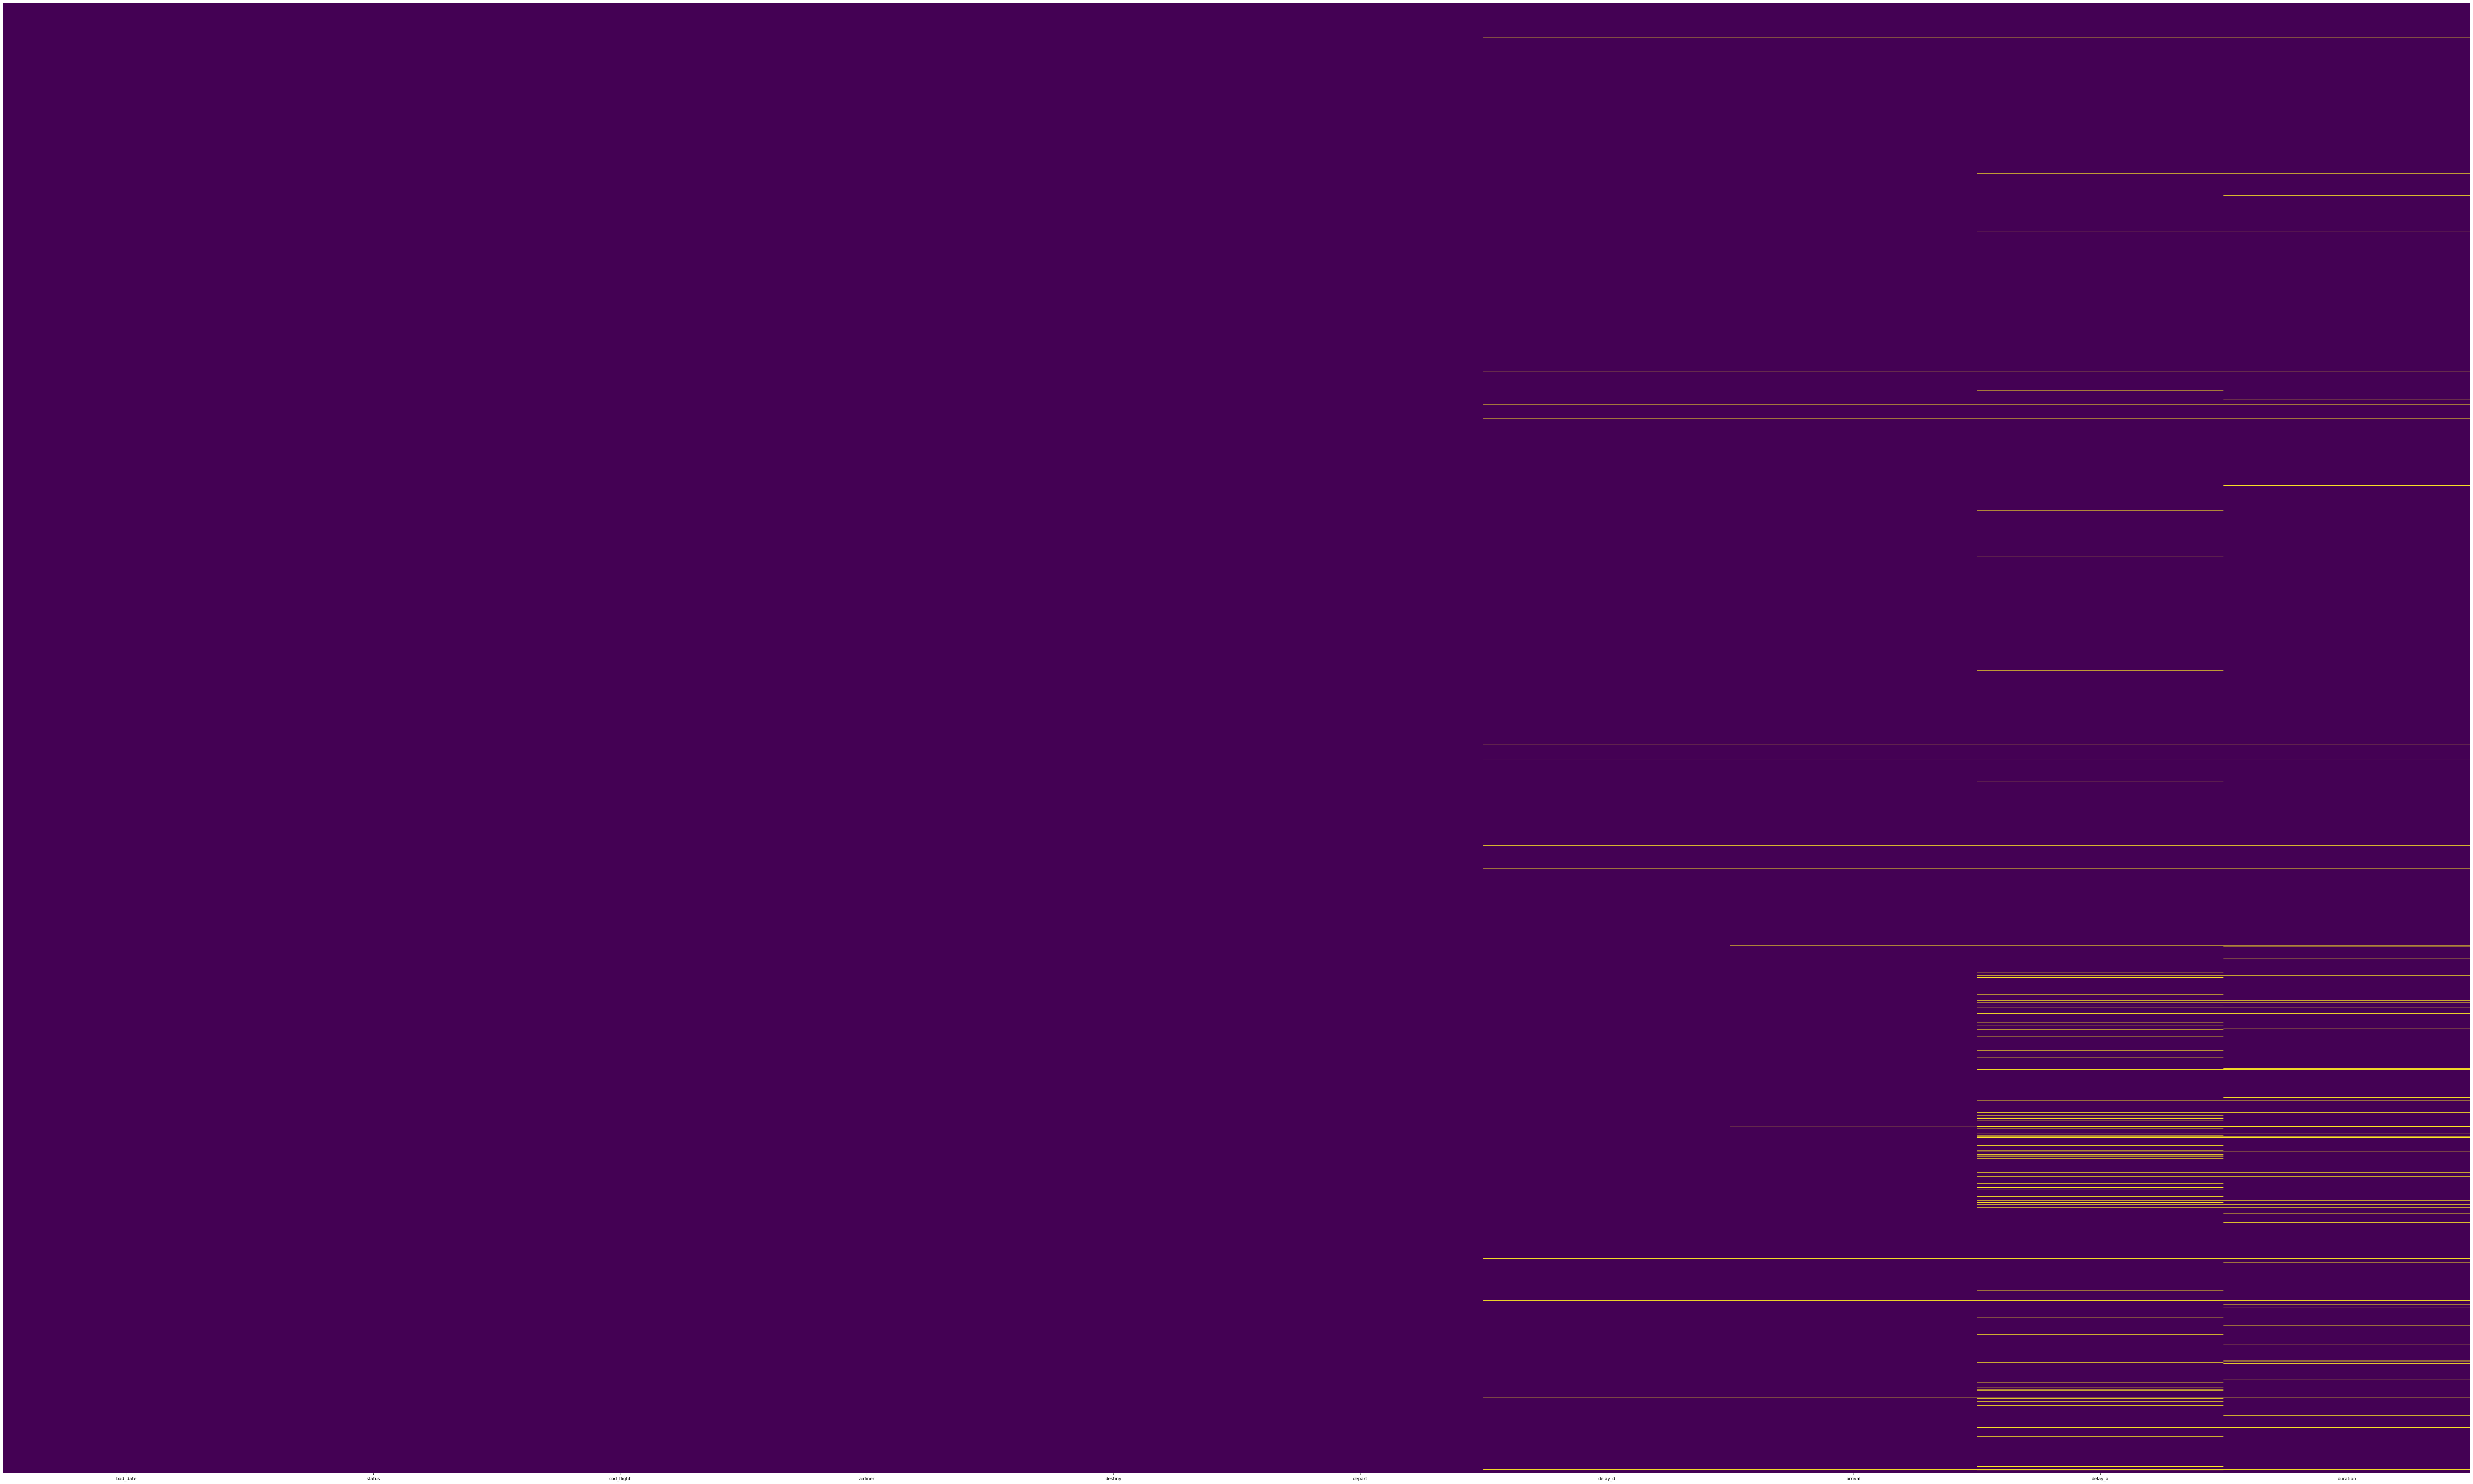

In [11]:
check_nan(fl)

In [12]:
fl.delay_d[fl.delay_d.isna()] = "-"
fl.arrival[fl.arrival.isna()] = "-"
fl.delay_a[fl.delay_a.isna()] = "-"
fl.duration[fl.duration.isna()] = "-"

In [13]:
fl.shape 

(482312, 10)

## Se eliminan los registros duplicados si los hubiere, y se eliminan aquellos registros de vuelos donde el estado sigue siendo *"Live"*.

In [14]:
fl = fl.drop_duplicates()

In [15]:
fl.shape 

(440127, 10)

In [16]:
fl[fl["status"] == "Live"].shape

(0, 10)

In [17]:
fl = fl[fl['status'] != 'Live']

In [4]:
pd.set_option('display.max_rows', None)
fl.bad_date.value_counts()

## Se genera una nueva columna con el día de la semana del vuelo, extrayendolo de la columna llamada *"bad_date"*.

In [19]:
dias_semana = {
    'Mon': 'Monday',
    'Tue': 'Tuesday',
    'Wed': 'Wednesday',
    'Thu': 'Thursday',
    'Fri': 'Friday',
    'Sat': 'Saturday',
    'Sun': 'Sunday'
}

In [20]:
fl['week_day'] = fl['bad_date'].str[:3].map(dias_semana)

In [21]:
fl = fl.reset_index()

In [22]:
fl.head()

,index,bad_date,status,cod_flight,airliner,destiny,depart,delay_d,arrival,delay_a,duration,week_day
0,0,"Wed, 01. Nov 2017",Landed,TP1005 TAP1005,TAP - Air Portugal,TP/TAP Porto (OPO / LPPR) 00:05 CET,31. Oct 23:05 UTC 00:12 CET,7min late,00:05 WET,10min early,52m,Wednesday
1,1,"Wed, 01. Nov 2017",Landed,IB3118 IBE3118,Iberia,IB/IBE Lisbon (LIS / LPPT) 00:10 CET,31. Oct 23:10 UTC 00:15 CET,5min late,00:09 WET,15min early,53m,Wednesday
2,2,"Wed, 01. Nov 2017",Landed,FX5036 FDX5036,Federal Express (FedEx),FX/FDX Paris (CDG / LFPG) 00:13 CET,31. Oct 23:13 UTC 00:13 CET,on time,01:40 CET,on time,1h 27m,Wednesday
3,3,"Wed, 01. Nov 2017",Landed,IB6841 IBE6841,Iberia,IB/IBE Buenos Aires (EZE / SAEZ) 00:40 CET,31. Oct 23:40 UTC 00:53 CET,13min late,08:47 UTC-03,37min early,11h 53m,Wednesday
4,4,"Wed, 01. Nov 2017",Landed,IB6409 IBE6409,Iberia,IB/IBE Mexico City (MEX / MMMX) 00:40 CET,31. Oct 23:40 UTC 01:11 CET,31min late,05:33 CST,16min early,11h 22m,Wednesday


In [23]:
fl = fl.drop(['index'], axis=1)

## Se utiliza una función propia (<span style="color:blue">convertir_fecha</span>) para transformar la columna "bad_date" a un formato Datetime reconocible por pandas.

In [24]:
fl['bad_date'] = fl['bad_date'].apply(convertir_fecha)

In [25]:
fl.week_day.value_counts()

Friday       66135
Thursday     64597
Wednesday    63912
Monday       63656
Sunday       63049
Tuesday      62975
Saturday     55803
Name: week_day, dtype: int64

## Se extraen los códigos IATA e ICAO del vuelo y se introducen en 2 nuevas columnas

In [26]:
fl[['cod_flight_IATA', 'cod_flight_ICAO']] = fl['cod_flight'].str.split(' ', expand=True)


## Se elimina la columna cod_flight una vez separados los 2 códigos

In [27]:
fl = fl.drop(['cod_flight'], axis=1)

## Se crea una funcion propia (<span style="color:blue">separar_valores</span>) que busca y separa en 2 columnas nuevas los códigos IATA e ICAO de la aerolínea que se encuentran en la columna "*destiny*"

In [28]:
separar_valores(fl, 'destiny')

In [29]:
fl[fl.cod_airliner_IATA.isnull()].airliner.value_counts()

Private owner                            261
Plus Ultra                               177
Johnsons Air                             177
United Nations                            94
Atlantic Airlines                         39
JUST Japan Universal System Transport     11
Cargo Air                                 11
WDL Aviation                               7
Bul Air                                    6
Via Airways                                5
Bulgarian Air Charter                      2
GetJet Airlines                            2
Sundair                                    2
Vueling Austria                            1
Americana de Aviacion                      1
Comlux Malta                               1
SprintAir                                  1
VistaJet Malta                             1
Jet Charter Inc ( Franklin Lakes Nj )      1
Airest                                     1
Name: airliner, dtype: int64

In [30]:
# Definir una función para aplicar a las columnas
def actualizar_codigos(row):
    if row['airliner'] == 'Plus Ultra':
        return pd.Series({'cod_airliner_IATA': 'PU', 'cod_airliner_ICAO': 'PUE'})
    elif row['airliner'] == 'Private owner':
        return pd.Series({'cod_airliner_IATA': 'PO', 'cod_airliner_ICAO': 'POW'})
    else:
        return pd.Series({'cod_airliner_IATA': row['cod_airliner_IATA'], 'cod_airliner_ICAO': row['cod_airliner_ICAO']})

# Aplicar la función a las columnas específicas
fl[['cod_airliner_IATA', 'cod_airliner_ICAO']] = fl.apply(actualizar_codigos, axis=1)


In [31]:
pd.set_option('display.max_columns', None)

##  Se crea una funcion propia (<span style="color:blue">extraer_valores</span>) que busca y separa en 3 columnas nuevas los códigos IATA e ICAO y el nombre de la ciudad de destino que se encuentran en la columna "*destiny*".

In [32]:
extraer_valores(fl, 'destiny')

In [33]:
fl = fl.dropna(subset="cod_airliner_IATA",axis = 0)

##  Se crea una funcion propia (<span style="color:blue">extraer_hora</span>) para extraer la hora programada de salida del vuelo, que se espera encontrar en la columna "*depart*"

In [34]:
extraer_hora(fl, 'destiny')

In [35]:
# fl[fl.depart_time.isna()].status.value_counts()

##  Se crea una funcion propia (<span style="color:blue">extraer_segunda_hora</span>) para extraer la hora real de salida del vuelo, que se espera encontrar en la columna "*depart*"

In [36]:
extraer_segunda_hora(fl, 'depart')


In [37]:
fl.depart_time[fl.depart_time.isna()] = "-"

In [38]:
fl.head()

,bad_date,status,airliner,destiny,depart,delay_d,arrival,delay_a,duration,week_day,cod_flight_IATA,cod_flight_ICAO,cod_airliner_IATA,cod_airliner_ICAO,City,cod_airport_IATA,cod_airport_ICAO,Scheduled_dep,depart_time
0,2017-11-01,Landed,TAP - Air Portugal,TP/TAP Porto (OPO / LPPR) 00:05 CET,31. Oct 23:05 UTC 00:12 CET,7min late,00:05 WET,10min early,52m,Wednesday,TP1005,TAP1005,TP,TAP,Porto,OPO,LPPR,00:05,00:12
1,2017-11-01,Landed,Iberia,IB/IBE Lisbon (LIS / LPPT) 00:10 CET,31. Oct 23:10 UTC 00:15 CET,5min late,00:09 WET,15min early,53m,Wednesday,IB3118,IBE3118,IB,IBE,Lisbon,LIS,LPPT,00:10,00:15
2,2017-11-01,Landed,Federal Express (FedEx),FX/FDX Paris (CDG / LFPG) 00:13 CET,31. Oct 23:13 UTC 00:13 CET,on time,01:40 CET,on time,1h 27m,Wednesday,FX5036,FDX5036,FX,FDX,Paris,CDG,LFPG,00:13,00:13
3,2017-11-01,Landed,Iberia,IB/IBE Buenos Aires (EZE / SAEZ) 00:40 CET,31. Oct 23:40 UTC 00:53 CET,13min late,08:47 UTC-03,37min early,11h 53m,Wednesday,IB6841,IBE6841,IB,IBE,Buenos Aires,EZE,SAEZ,00:40,00:53
4,2017-11-01,Landed,Iberia,IB/IBE Mexico City (MEX / MMMX) 00:40 CET,31. Oct 23:40 UTC 01:11 CET,31min late,05:33 CST,16min early,11h 22m,Wednesday,IB6409,IBE6409,IB,IBE,Mexico City,MEX,MMMX,00:40,01:11


## Se eliminan las columnas "sucias" "*destiny*" y "*depart*" y se sustituyen los valores "scheduled" por "" en la columna "*duration*".

In [39]:
fl = fl.drop(['destiny'], axis=1)
fl = fl.drop(['depart'], axis=1)

In [40]:
fl['duration'] = fl['duration'].str.replace('scheduled', '')

In [41]:
fl['duration'] = fl['duration'].str.replace('Estimated', '')

In [1]:
# fl.duration.value_counts()

##  Se crea una funcion propia (<span style="color:blue">redondear_horas</span>) para redondear la duracion del vuelo en horas, y poner "1h" en los vuelos de ">1h".

In [43]:
fl['duration'] = fl['duration'].apply(redondear_horas)

In [44]:
fl['duration'] = fl['duration'].str.replace(' ', '')

In [45]:
fl["duration"][fl["duration"]==""] = "-"

In [2]:
# fl.delay_a.value_counts()

## Se crea una nueva columna que combine la fecha y la hora prevista de salida de vuelo en formato datetime, para luego poder ordenar los vuelos cronológicamente.

In [47]:
fl['Departure_date_time'] = pd.to_datetime(fl['bad_date'] + ' ' + fl['Scheduled_dep'])

In [48]:
fl = fl.sort_values(by='Departure_date_time', ascending=False)

In [49]:
fl = fl.reset_index(drop = True)

##  Se crea una funcion propia (<span style="color:blue">asignar_estado_departure</span>) que busca el estado de la salida del vuelo que se espera encontrar en la columna "*delay_d*" y se crea una nueva columna.

In [50]:
fl['dep_situation'] = fl['delay_d'].apply(asignar_estado_departure)

In [51]:
# fl.delay_d.value_counts()

##  Se crea una funcion propia (<span style="color:blue">calcular_minutos</span>) que suma los minutos de retraso o adelanto en la salida en función del estado del departure.

In [52]:
fl['dep_mins_of_delay'] = fl['delay_d'].apply(calcular_minutos)

In [53]:
fl[fl.dep_mins_of_delay.isna()]

,bad_date,status,airliner,delay_d,arrival,delay_a,duration,week_day,cod_flight_IATA,cod_flight_ICAO,cod_airliner_IATA,cod_airliner_ICAO,City,cod_airport_IATA,cod_airport_ICAO,Scheduled_dep,depart_time,Departure_date_time,dep_situation,dep_mins_of_delay


## Se aplica tambien la función  (<span style="color:blue">calcular_minutos</span>) para las llegadas.

In [55]:
fl['arr_mins_of_delay'] = fl['delay_a'].apply(calcular_minutos)


In [56]:
fl[["delay_d","dep_mins_of_delay","delay_a","arr_mins_of_delay"]].head(10)

,delay_d,dep_mins_of_delay,delay_a,arr_mins_of_delay
0,5min late,5,9min early,-9
1,2min early,-2,20min early,-20
2,19min late,19,12min late,12
3,15min late,15,1min early,-1
4,9min late,9,12min early,-12
5,18min late,18,17min early,-17
6,10min early,-10,2min early,-2
7,3min late,3,3min early,-3
8,17min late,17,21min early,-21
9,4min early,-4,16min early,-16


##  Se crea una funcion propia (<span style="color:blue">calcular_diferencia</span>) que calcula la diferencia entre los minutos de retraso/adelanto en la salida y la llegada para ver anomalías en los registros.

In [57]:
fl["resta"] = fl.apply(calcular_diferencia, axis=1)

In [58]:
fl[["delay_d","dep_mins_of_delay","delay_a","arr_mins_of_delay","resta"]].head()

,delay_d,dep_mins_of_delay,delay_a,arr_mins_of_delay,resta
0,5min late,5,9min early,-9,14
1,2min early,-2,20min early,-20,18
2,19min late,19,12min late,12,7
3,15min late,15,1min early,-1,16
4,9min late,9,12min early,-12,21


In [59]:
len(fl[abs(fl.resta) > 100])

1266

## Se aplica tambien la función  (<span style="color:blue">asignar_estado_departure</span>) para las llegadas.

In [60]:
fl['arr_situation'] = fl['delay_a'].apply(asignar_estado_departure)

In [61]:
fl.arr_situation.value_counts()

early      235357
late       150154
on time     41704
-           12549
Name: arr_situation, dtype: int64

## Se añade un *id* a cada uno de los vuelos

In [62]:
fl['flight_id'] = range(1, len(fl) + 1)

## Se eliminan columnas sucias y se reordenan las restantes cambiando alguno de sus nombres.

In [63]:
fl = fl.drop(['delay_d'], axis=1)
fl = fl.drop(['delay_a'], axis=1)

In [64]:
reorder = ["flight_id","Departure_date_time","cod_flight_IATA","cod_flight_ICAO","bad_date","week_day","status","airliner","cod_airliner_IATA","cod_airliner_ICAO",
           "Scheduled_dep","depart_time","dep_situation","dep_mins_of_delay","City","cod_airport_IATA","cod_airport_ICAO","arrival",
           "arr_situation","arr_mins_of_delay","duration","resta"]
fl = fl[reorder]

In [65]:
fl.head()

,flight_id,Departure_date_time,cod_flight_IATA,cod_flight_ICAO,bad_date,week_day,status,airliner,cod_airliner_IATA,cod_airliner_ICAO,Scheduled_dep,depart_time,dep_situation,dep_mins_of_delay,City,cod_airport_IATA,cod_airport_ICAO,arrival,arr_situation,arr_mins_of_delay,duration,resta
0,1,2022-01-01 07:25:00,IB3866,IBS38TK,2022-01-01,Saturday,Landed,Iberia,IB,IBE,07:25,07:30,late,5,Malaga,AGP,LEMG,08:30 CET,early,-9,59m,14
1,2,2022-01-01 07:25:00,IB3832,IBS3832,2022-01-01,Saturday,Landed,Iberia,IB,IBE,07:25,07:23,early,-2,Las Palmas,LPA,GCLP,08:59 WET,early,-20,3h,18
2,3,2022-01-01 07:25:00,IB8746,ANE8746,2022-01-01,Saturday,Landed,Iberia,IB,IBE,07:25,07:44,late,19,Marseille,MRS,LFML,09:22 CET,late,12,2h,7
3,4,2022-01-01 07:20:00,FR5278,RYR15NV,2022-01-01,Saturday,Landed,Ryanair,FR,RYR,07:20,07:35,late,15,Tenerife,TFN,GCXO,09:13 WET,early,-1,3h,16
4,5,2022-01-01 07:20:00,FR5991,RYR1ZK,2022-01-01,Saturday,Landed,Ryanair,FR,RYR,07:20,07:29,late,9,Milan,BGY,LIME,09:22 CET,early,-12,2h,21


In [66]:
fl = fl.rename(columns ={'City':'city', 'Departure_date_time':'departure_date_time', "bad_date": "day"})

## Nos quedamos exclusivamente con los vuelos del rango de fechas deseados.

In [67]:
fl = fl[(fl["departure_date_time"] < "2020-01-01") & (fl["departure_date_time"] >= "2017-11-01")]

## Se reindexa y se exportan los datos limpios en formato *csv*.

In [68]:
fl['flight_id'] = range(1, len(fl) + 1)
fl = fl.reset_index(drop = True)
fl.head()

,flight_id,departure_date_time,cod_flight_IATA,cod_flight_ICAO,day,week_day,status,airliner,cod_airliner_IATA,cod_airliner_ICAO,Scheduled_dep,depart_time,dep_situation,dep_mins_of_delay,city,cod_airport_IATA,cod_airport_ICAO,arrival,arr_situation,arr_mins_of_delay,duration,resta
0,1,2019-12-31 23:55:00,UX25,AEA025,2019-12-31,Tuesday,Landed,Air Europa,UX,AEA,23:55,00:09,late,14,Santa Cruz,VVI,SLVR,06:35 UTC-04,early,-10,11h,24
1,2,2019-12-31 23:55:00,LA705,LAN705,2019-12-31,Tuesday,Landed,LATAM Airlines Chile,LA,LAN,23:55,23:41,early,-14,Santiago,SCL,SCEL,09:24 UTC-03,early,-6,14h,-8
2,3,2019-12-31 23:55:00,IB6011,IBE6011,2019-12-31,Tuesday,Landed,Iberia,IB,IBE,23:55,23:44,early,-11,Montevideo,MVD,SUMU,08:28 UTC-03,early,-21,13h,10
3,4,2019-12-31 23:55:00,UX175,AEA175,2019-12-31,Tuesday,Landed,Air Europa,UX,AEA,23:55,00:03,late,8,Lima,LIM,SPJC,05:29 UTC-05,early,-25,11h,33
4,5,2019-12-31 23:55:00,IB6827,IBE6827,2019-12-31,Tuesday,Landed,Iberia,IB,IBE,23:55,23:51,early,-4,Sao Paulo,GRU,SBGR,06:59 UTC-03,late,4,11h,-8


In [82]:
fl.shape

(439088, 22)

In [70]:
fl.tail()

,flight_id,departure_date_time,cod_flight_IATA,cod_flight_ICAO,day,week_day,status,airliner,cod_airliner_IATA,cod_airliner_ICAO,Scheduled_dep,depart_time,dep_situation,dep_mins_of_delay,city,cod_airport_IATA,cod_airport_ICAO,arrival,arr_situation,arr_mins_of_delay,duration,resta
439670,439671,2017-11-01 00:40:00,IB6409,IBE6409,2017-11-01,Wednesday,Landed,Iberia,IB,IBE,00:40,01:11,late,31,Mexico City,MEX,MMMX,05:33 CST,early,-16,11h,47
439671,439672,2017-11-01 00:40:00,IB6841,IBE6841,2017-11-01,Wednesday,Landed,Iberia,IB,IBE,00:40,00:53,late,13,Buenos Aires,EZE,SAEZ,08:47 UTC-03,early,-37,12h,50
439672,439673,2017-11-01 00:13:00,FX5036,FDX5036,2017-11-01,Wednesday,Landed,Federal Express (FedEx),FX,FDX,00:13,00:13,on time,0,Paris,CDG,LFPG,01:40 CET,on time,0,1h,0
439673,439674,2017-11-01 00:10:00,IB3118,IBE3118,2017-11-01,Wednesday,Landed,Iberia,IB,IBE,00:10,00:15,late,5,Lisbon,LIS,LPPT,00:09 WET,early,-15,53m,20
439674,439675,2017-11-01 00:05:00,TP1005,TAP1005,2017-11-01,Wednesday,Landed,TAP - Air Portugal,TP,TAP,00:05,00:12,late,7,Porto,OPO,LPPR,00:05 WET,early,-10,52m,17


In [80]:
fl2 = fl_ori.copy()

In [83]:
fl.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439088 entries, 0 to 439674
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   flight_id            439088 non-null  int64         
 1   departure_date_time  439088 non-null  datetime64[ns]
 2   cod_flight_IATA      439088 non-null  object        
 3   cod_flight_ICAO      426378 non-null  object        
 4   day                  439088 non-null  object        
 5   week_day             439088 non-null  object        
 6   status               439088 non-null  object        
 7   airliner             439088 non-null  object        
 8   cod_airliner_IATA    439088 non-null  object        
 9   cod_airliner_ICAO    439088 non-null  object        
 10  Scheduled_dep        439088 non-null  object        
 11  depart_time          439088 non-null  object        
 12  dep_situation        439088 non-null  object        
 13  dep_mins_of_de

In [84]:
fl.status.value_counts()

Landed       436824
Diverted       1174
Cancelled      1069
Unknown          21
Name: status, dtype: int64

In [85]:
# fl.to_csv("../data/flights/flights2017_2019.csv", index=False)